In [13]:
library(repr)
options(repr.plot.width=7, repr.plot.height=4.5)

# stdViz.R
This initial Jupyter notebook of ggplot charts explores visualizations of session activity over time, usually AAS, and broken down by wait class or other dimensions.

## Install ashdat and ggplot
Having finally gotten the ashdat package created, I can load it into my Jupyter notebook and access the STMAIL data frame directly. Very nice.

The dplyr package is useful for data reduction pipelines. And of course we need ggplot!

In [2]:
# TODO: host the ashdat package somewhere on web, probably Github

# install ashdat from current directory
install.packages("./ashdat_0.1.0.tar.gz", repos = NULL)

library(ashdat)
library(dplyr)
library(ggplot2)

## ashdat::STMAIL data frame
In my original `Setup.R` script, `ashDF` is the name of the ASH dump data frame used to develop the plots. We maximize re-usability of that code by re-creating `ashDF` here using the `ashdat` package and the `STMAIL` data frame stored there.

In [15]:
ashDF <- ashdat::STMAIL
str(ashDF)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	214204 obs. of  39 variables:
 $ DBID                    : Factor w/ 1 level "3500743502": 1 1 1 1 1 1 1 1 1 1 ...
 $ INSTANCE_NUMBER         : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ SAMPLE_ID               : int  35545015 35545015 35545015 35545015 35545015 35545015 35545015 35545015 35545015 35545015 ...
 $ SAMPLE_TIME             : POSIXct, format: "2006-10-09 12:19:24" "2006-10-09 12:19:24" ...
 $ SESSION_ID              : Factor w/ 620 levels "1522","1526",..: 22 39 75 83 92 111 120 137 163 234 ...
 $ SESSION_SERIAL.         : Factor w/ 1391 levels "1","3","4","5",..: 16 494 791 222 13 616 706 66 92 11 ...
 $ USER_ID                 : Factor w/ 6 levels "0","5","24","55",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ SQL_ID                  : Factor w/ 1189 levels "","0486hsh0p6hcm",..: 380 243 238 222 243 222 380 222 111 243 ...
 $ SQL_CHILD_NUMBER        : Factor w/ 39 levels "0","1","2","3",..: 2 4 3 1 4 1 2 1 1 4 ...
 $ SQL_PLA

Bingo, we have a nicely manicured data frame of the original ASH dump data, handed to us through the ashdat package. Over 200,000 observations from 4 RAC instances with microsecond time stamps! Note that all columns are marked as factors, with the exception of dates, timers, EST_COUNT and SAMPLE_ID.
Most of the columns are straight from ASH, but some important additions are:
- EST_COUNT : this is the estimated event count based on measured sample latency (assuming default 1000ms sampling interval)
- STATE: either CPU, WAIT or I/O to draw the basic three-state perf chart
- MINIT: SAMPLE_TIME truncated to the minute

The above sequence of package loading / attaching and creation of the ashDF data frame are common across notebooks that use the ashdat package for data. 

## Sampled Session Activity over Time

### summarize ashDF
The following data frame (d, should have a good name) is a summary of ashDF with the total number of active sessions (AS) broken out by instance, sample and wait class. Both SAMPLE_ID and SAMPLE_TIME are selected but these are identical within an instance.

In [16]:
d <- ashDF %>% group_by(INSTANCE_NUMBER,SAMPLE_TIME,SAMPLE_ID,WAITCLASS) %>% summarize(AS=n())

### geom_point ( )
Using the SAMPLE_TIME for x and AS (Active Sessions) for y we color by WAITCLASS and plot points for every distinct sample time and wait class. Note that since ASH samplers are independent across instances the set of sample times will not likely intersect and thus sample times will uniquely identify samples (with high likelihood.) An attempt to mitigate overplotting with alpha = .5 is less than successful.

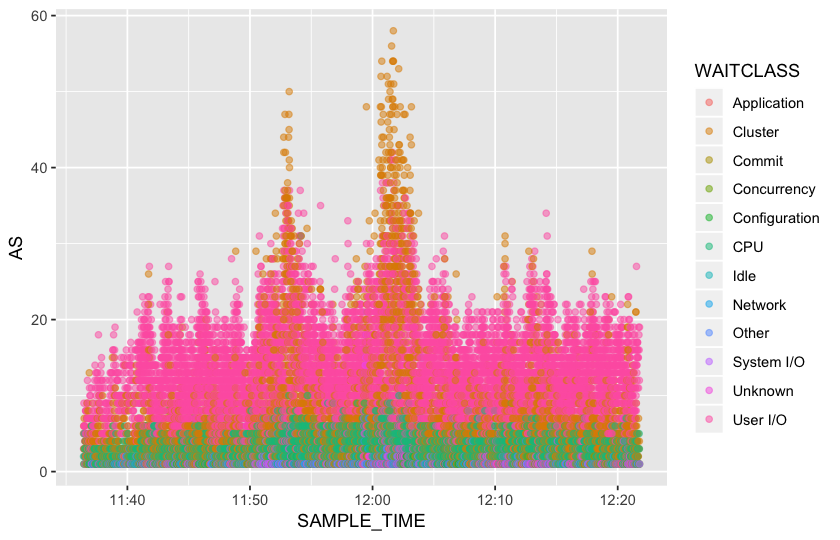

In [17]:
p <- ggplot(data = d, aes(x = SAMPLE_TIME, y = AS, color = WAITCLASS))
p + geom_point(alpha=.5)

The chart above shows two spikes in activity, at 11:53 and 12:02. Other than that it is difficult to read much out of it due to the massive overplotting. 

Reducing the point size to .2 puts a finer point on things (ugh) although the picture is not necessarily much clearer. The horizontal striping is a reminder that session counts for each sample are whole numbers, so y values will only be such. 

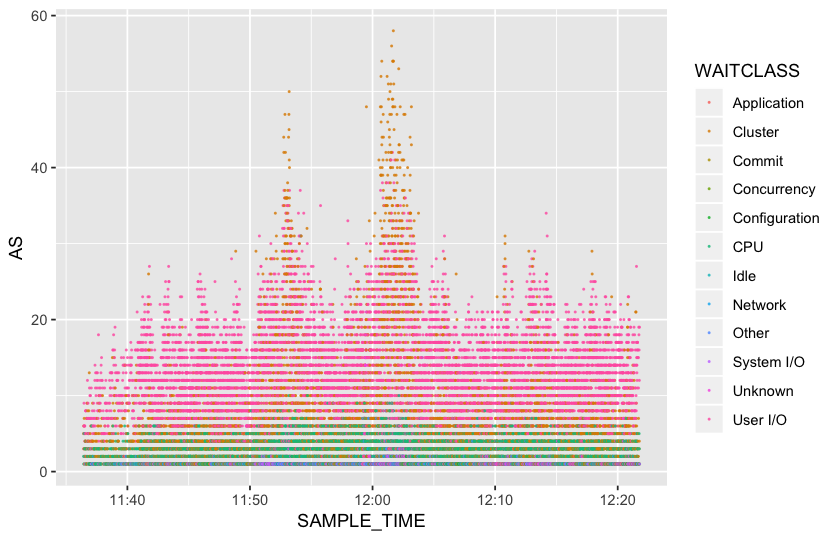

In [18]:
p <- ggplot(data = d, aes(x = SAMPLE_TIME, y = AS, color = WAITCLASS))
p + geom_point(alpha = 0.7, size = .2)

## Average Active Sessions (AAS) by Minute
Create a data frame grouping by `MINIT` and `WAITCLASS` and computing: `AAS = n()/60`.

AAS is total samples divided by 60 assuming default sampling interval of 1000 ms (= 1 sec):
* seconds / 60 = minutes
* minutes / minutes = AAS 

In [19]:
d2 <- ashDF %>% group_by( MINIT, WAITCLASS) %>% summarize( AAS = n()/60)

## geom_line( )
Using `x = MINIT` and `y = AAS` for aesthetic mappings we color by `WAITCLASS` and use `geom_line` for the geometry:

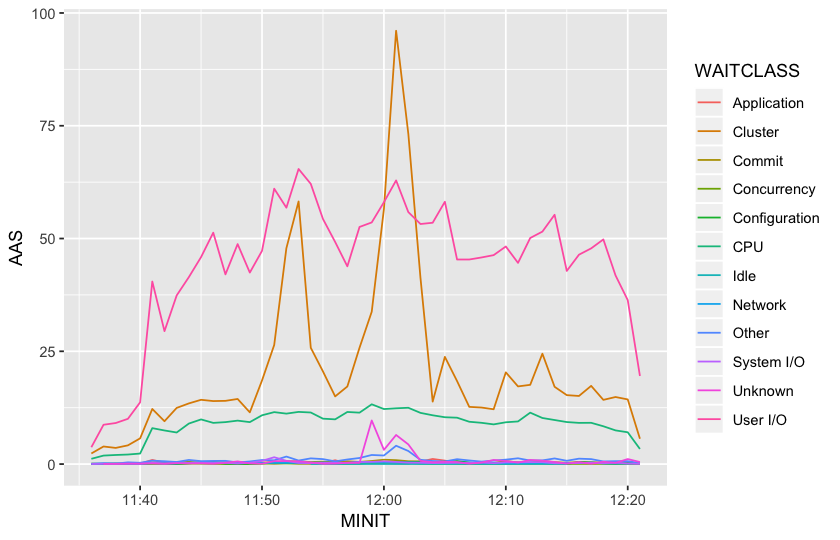

In [20]:
# set up plot aesthetics
p <- ggplot(data = d2, aes(x = MINIT, y=AAS, color = WAITCLASS))
# add geom to plot
p + geom_line()

The chart above is interesting and informative. We can clearly map the spikes in activity to a single wait class: Cluster. Almost all of the other activity is either User I/O or CPU, with the exception of an interesting blip in a couple of classes around 12:00.

Faceting by `INSTANCE_NUMBER` may reveal whether the spikes in Cluster wait activity were specific to instances or cluster-wide. In this case the spikes seem quite equally shared across the instances.

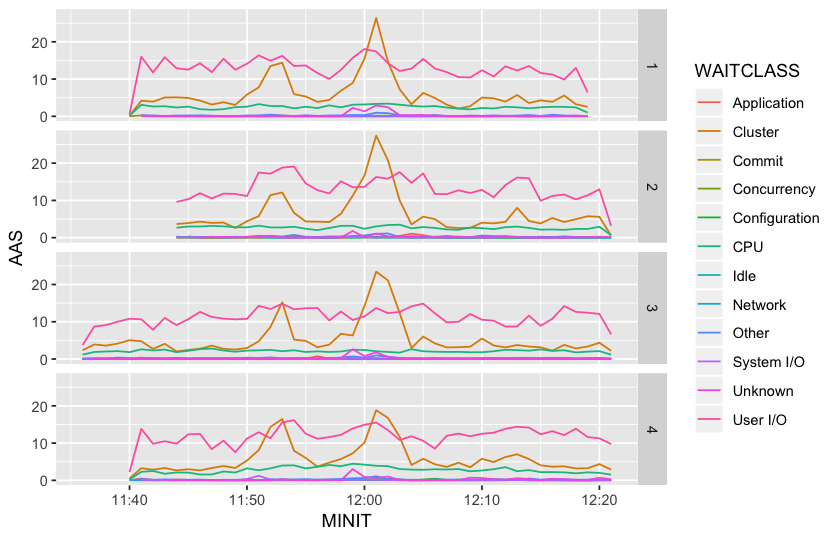

In [21]:
# set up instance, minit, waitclass 
d3 <- ashDF %>% group_by(INSTANCE_NUMBER, MINIT, WAITCLASS) %>% summarize(AAS = n()/60)
# use d and chart AAS by minute for each wait class
p <- ggplot(data = d3, aes(x = MINIT, y=AAS, color = WAITCLASS))
# use lines and facet by instance
p + geom_line() + facet_grid( INSTANCE_NUMBER ~. )

The plot above also evidences good workload sharing across the RAC instances, as activity levels in all the wait classes are very closely matched. 

We can reverse the roles of `WAITCLASS` and `INSTANCE`, faceting by the former and coloring by the latter:

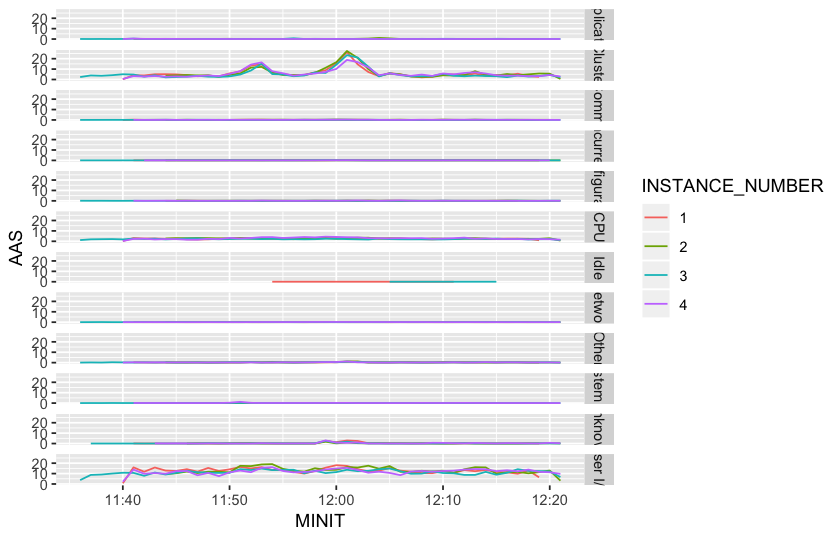

In [22]:
p <- ggplot(data = d3, aes(x = MINIT, y=AAS, color = INSTANCE_NUMBER))
# use lines and facet by instance
p + geom_line() + facet_grid( WAITCLASS ~. )

The vertical "squashing" flatlines all classes except Cluster and User I/O. The instance coloring is rendered useless by overplotting. Fail.

Using scales = "free" we can allow each facet (class) y-axis to scale independently. This shows differences across instances within class pretty well, but the relative unimportance of low activity classes is lost to the visual dynamism.

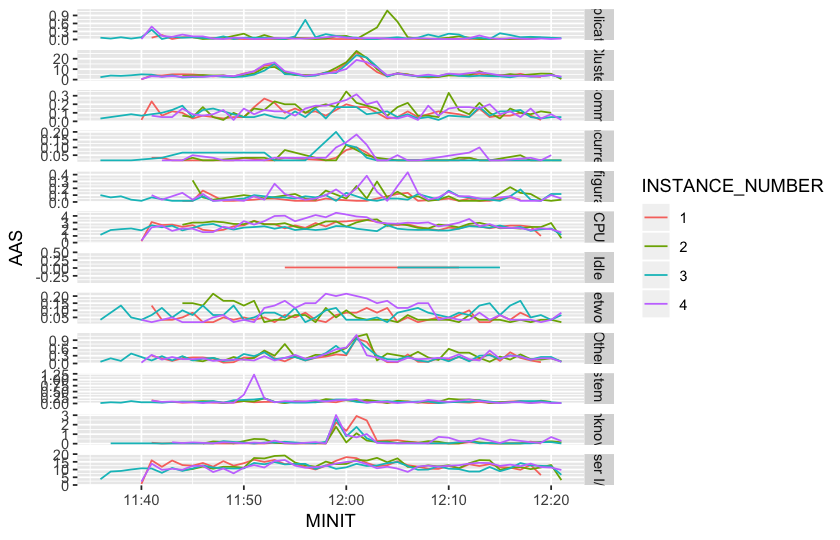

In [23]:
p + geom_line() + 
  facet_grid( WAITCLASS ~. ,scales = "free" )

## Classic Perf Chart: CPU, I/O, WAIT by MINIT
We will create the classic stacked activity chart showing Average Active Sessions in CPU, I/O and WAIT summarized over 1-minute time intervals.

First, summarize `ashDF` by `MINIT` and `STATE`, computing `AAS`:

In [24]:
d4 <- ashDF %>% group_by(MINIT, STATE) %>% summarize(AAS = n()/60)

## geom_area ( )

Using `geom_area( )` to plot `AAS` by `STATE` over time in minutes:

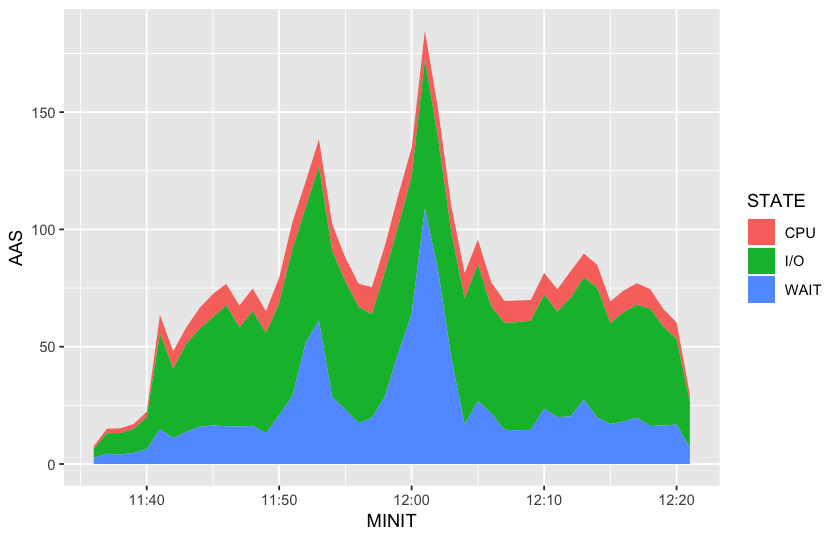

In [25]:
p <- ggplot(d4, aes(x = MINIT, y = AAS, fill = STATE))
#
p + geom_area()

This is the thumbnail version of the classic EM Activity Chart, with a couple of issues:
* Colors mismatched: CPU should be green, I/O blue, WAIT red
* Stacking order wrong: should be CPU bottom, I/O middle, WAIT top

We can adjust the colors using a state-color mapping vector and passing it to `scale_fill_manual`.

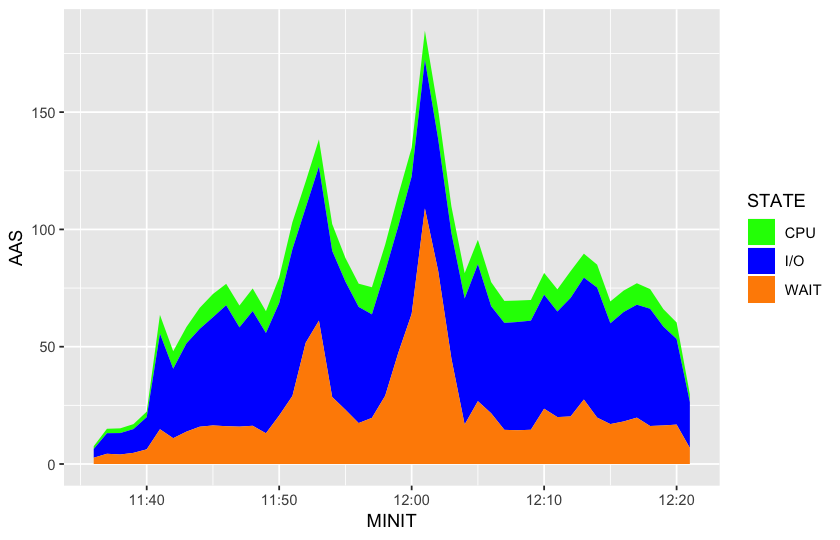

In [26]:
# use more standard colors for CPU, I/O and WAIT
statecolors <- c("CPU" = "green", "I/O" = "blue", "WAIT" = "dark orange")
# re-initialize plot
p <- ggplot(d4, aes(x = MINIT, y = AAS, fill = STATE))
# plot with new colors for state
p + geom_area() + scale_fill_manual( values = statecolors )

Finally we can re-order the `STATE` factor levels and stack the areas in the desired order to get something closely resembling the classic DB Activity chart.

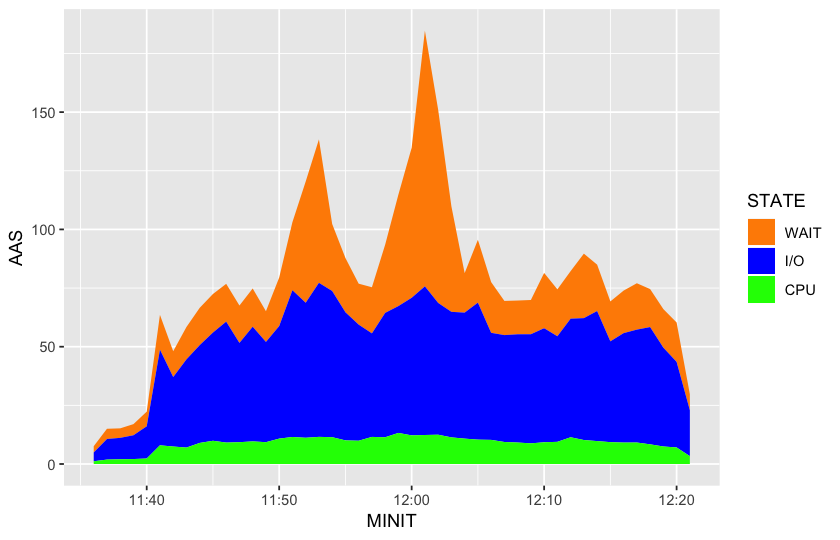

In [27]:
# re-order STATE factor
d4$STATE <- factor( d4$STATE, levels = c("WAIT", "I/O", "CPU") )
#
# re-initialize plot with new levels
p <- ggplot(d4, aes(x = MINIT, y = AAS, fill = STATE))
#
p + geom_area() + scale_fill_manual( values = statecolors )

## SAMPLE_ID vs SAMPLE_TIME
In my initial experiments using `geom_point( )` I used the SAMPLE_ID instead of `SAMPLE_TIME` for the x-axis, with some at first confusing results. Here is an example:

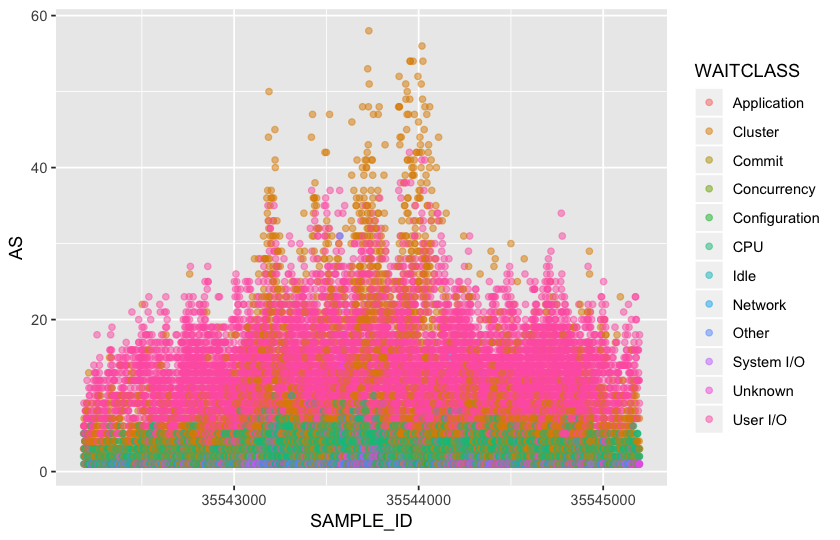

In [28]:
ggplot(data = ashDF %>% group_by( INSTANCE_NUMBER, SAMPLE_ID, WAITCLASS ) %>% summarize (AS = n() )
      ,aes( x = SAMPLE_ID, y = AS, color = WAITCLASS)) +  geom_point(alpha=.5)

Note the difference in overall look when `SAMPLE_ID` is used for the x-axis. The two activity spikes are not so visible and in fact appear to have become 4 spikes, one per instance. This is because `SAMPLE_ID`s across instances do not line up in time, potentially very misleading.

Conclusion: never use `SAMPLE_ID` for time, always use `SAMPLE_TIME`.

Coloring by `INSTANCE_NUMBER` shows the 4 instances appear to spike together in pairs in `SAMPLE_ID` space: 1 & 2 together, and 3 & 4 together:

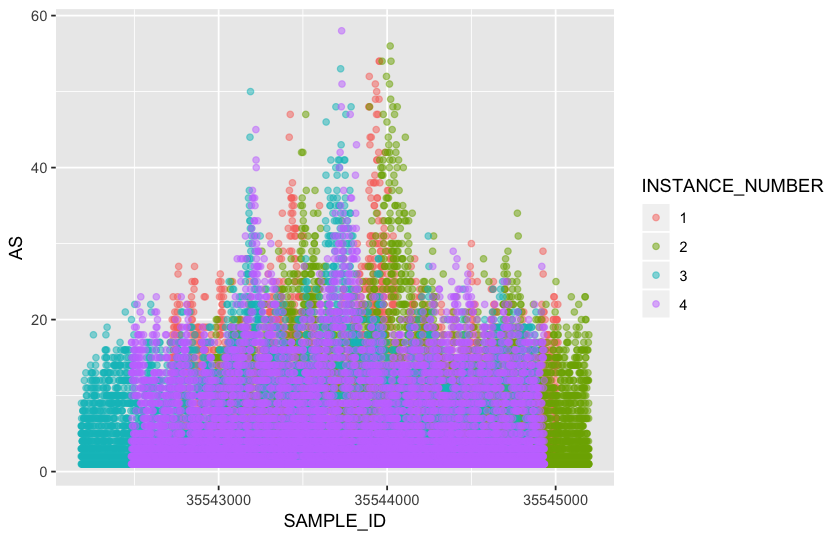

In [29]:
ggplot(data=d,aes(x=SAMPLE_ID,y=AS,color=INSTANCE_NUMBER)) +  
  geom_point(alpha=.5)

So I wanted to investigate the relationship of `SAMPLE_ID` to `SAMPLE_TIME` for each of the 4 instances. A simple line chart can do the trick.

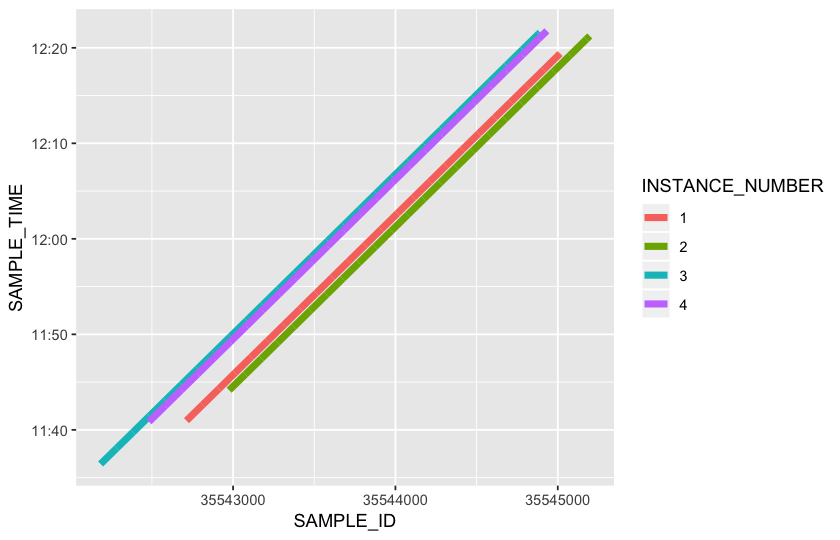

In [30]:
ggplot( data = d %>% distinct(INSTANCE_NUMBER, SAMPLE_ID, SAMPLE_TIME)
       ,aes(x=SAMPLE_ID, y=SAMPLE_TIME, color=INSTANCE_NUMBER)) + geom_line(size=2)

Of course I didn't follow my own advice and used SAMPLE_ID instead of SAMPLE_TIME for the x-axis. Fixing that doesn't materially change the chart, but feels much better.

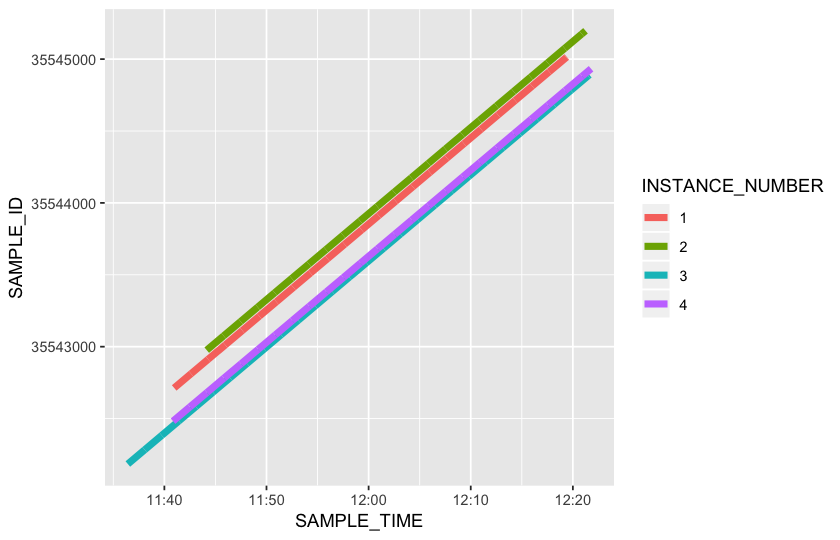

In [31]:
ggplot( data = d %>% distinct(INSTANCE_NUMBER, SAMPLE_ID, SAMPLE_TIME)
       ,aes(y=SAMPLE_ID, x=SAMPLE_TIME, color=INSTANCE_NUMBER)) + geom_line(size=2)

So this plot is surprisingly informative, even as it is simple. For one, we see why the instances spiked together in pairs. Lines close to each other in this chart indicate instances whose `SAMPLE_ID`s and `SAMPLE_TIME`s match closely. Also note that the last `SAMPLE_TIME` of instance 1 precedes that of the other instances by several minutes. Perhaps the ASH dump was triggered from this instance and finished earlier?

Finally, there is a sizeable gap of perhaps 500 `SAMPLE_ID`s between the instance {1,2} group and the {3,4} group. Without knowing more about how the independent ASH samplers operate in a RAC context it is difficult to speculate what this might indicate.

## The DB Performance Page
We can use `geom_col( )` and to plot stacked bar chart of total DB activity by wait class over 1-minute intervals, which is essentially the classic DB Performance Page view of the world. I'm not going to bother matching the wait class colors though, not worth the effort here.  

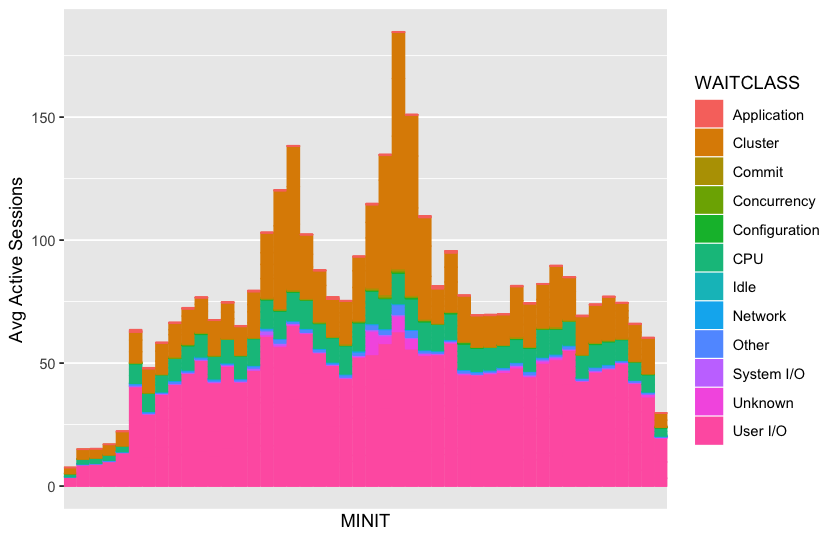

In [32]:
## create one-minute summaries of AAS by WAITCLASS and INSTANCE
d3 <- ashDF %>% 
      group_by(INSTANCE_NUMBER,MINIT,WAITCLASS) %>% 
      summarize(AAS = n()/60 ) 
#
# plot global AAS by WAITCLASS per minute
ggplot(data=d3,aes(x=MINIT,y=AAS,color=WAITCLASS)) + 
     geom_col(aes(fill=WAITCLASS)) +
     scale_x_discrete(labels = NULL) + ylab("Avg Active Sessions")

# Learnings
- `install.packages( )`
- `dplyr::%>%`
- `geom_point( )`
- `geom_area( )`
- `geom_line( )`
- `geom_col( )`
- faceting, colors, alpha, size
- computing AAS

# References
1. R ggplot book
2. R packages book